# Importando bibliotecas

Primeiramente, é preciso importar, para o Jupyter Notebook, as bibliotecas necessárias para o funcionamento dos processos realizados. Os pacotes Pandas e Numpy são de uso fundamental em Python e serão utilizados na análise exploratória dos dados, bem como em sua posterior limpeza e tratamento. Scikit-Learn, por outro lado, é uma biblioteca Python aplicada a Machine Learning, e suas ferramentas serão essenciais para o desenvolvovimento do modelo preditivo.

In [ ]:
!pip install -U -q PyDrive

In [ ]:
import pandas as pd
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

# Safra Artificial

A primeira opção para a qual foram aplicados os modelos preditivos desenvolvidos se refere aos registros de uma safra artificial. A partir disso, foram selecionados todos os registros contidos no dataframe, de modo que as proporções relacionadas a determinadas features (colunas) fossem devidamente balanceadas. Assim, ao invés de selecionar uma única safra para basear o modelo preditivo, todas as safras existentes foram consideradas.

# Carregando dados

In [ ]:
# Autenticação para acesso aos dados
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Download dos dados para esta máquina virtual
downloaded = drive.CreateFile({'id': '1DUV-TOm5NhiaDfBgewwh26Ky7jgoC1mU'})
downloaded.GetContentFile('data.csv')

In [ ]:
# Carregamento dos dados baixados em um dataframe 
df = pd.read_csv('data.csv')
df.head()

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
0,202104,fffff8b0db8eff291be8b83f8885f52c52782bb42c3c4b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,202104,ffffd54b45ec46113523184fc07185a0d5cbfa876a07ba...,35943.74,5815.5,NaN,377.0,1.0,NaN,24.0,NaN,10.0,NaN,A,NaN,1.0,NaN
2,202104,ffffd47a92b3e4291c013033ae528708a19eaede50f78e...,6288.22,NaN,NaN,257.0,NaN,NaN,22.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN
3,202104,ffffc102ddd37ec29e985a4564e85a2bace79a85ebff5e...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
4,202104,ffffbd4a3d42a12e07b1202d68c33d43220c42c8a55160...,1238.93,1400.0,NaN,773.0,2.0,NaN,21.0,NaN,NaN,NaN,A,NaN,1.0,NaN


# Análise exploratória dos dados

In [ ]:
# Importação da biblioteca Plotly, que cria gráficos interativos para a visualização dos dados
import plotly.express as px

A seguir, estamos calculando as médias de algumas features que podem ser relevantes para o posterior treinamento do nosso modelo preditivo, a fim de melhor entender a situação dos clientes como um todo.


In [ ]:
# Cálculo de médias
medias = df[['vlr_credito', 'vlr_saldo', 'vlr_score', 'num_atend_atrs', 'num_produtos']].sum()/len(df)
print(medias)
medias.dtypes

medias = pd.DataFrame(medias)

# Criação de gráfico para a visualização das médias obtidas
fig = px.bar(medias, y=medias[0], height=400, width=700, title='Média de crédito, saldo, score, atendimentos atrasados e produtos')
fig.update_xaxes(type='category')
fig.show()

vlr_credito       17473.173800
vlr_saldo          3020.682365
vlr_score           329.011591
num_atend_atrs        0.000579
num_produtos          0.837787
dtype: float64


Aqui, comparamos a quantidade de atendimentos existentes com a quantidade de atendimentos que se encontram atrasados.


In [ ]:
# Média de atendimentos e atendimentos atrasados
atends = df[['num_atend', 'num_atend_atrs']].sum()/len(df)
df_atends = pd.DataFrame(atends)

# Geração de gráfico com as médias obtidas anteriormente
fig = px.bar(df_atends, y=df_atends[0], height=400, width=600)
fig.update_xaxes(type='category')
fig.show()

In [ ]:
# Descrição da quantidade de reclamações
num_reclm = df['qtd_reclm'].describe()

# Criação de um data frame com os números encontrados anteriormente.
num_reclm_1 = pd.DataFrame(num_reclm)

# Retirada do parâmtro count desse df (data frame) criado
num_reclm_1 = num_reclm_1.drop('count')

# Criação de um gráfico para a melhor visualização desses valores
figReclm = px.bar(num_reclm_1, y=num_reclm_1['qtd_reclm'], height=400, width=600)
figReclm.update_xaxes(type='category')
figReclm.show()

In [ ]:
# Análise de clientes que buscam novos produtos/atritados

# NAN das colunas vlr_credito, vlr_saldo e num_produtos sendo trocados por 0;
data= df[['vlr_credito', 'vlr_saldo', 'num_produtos']].replace(np.nan, 0)

# Gera-se um novo dataframe com as informações específicas
data = pd.DataFrame(data);

# Pega-se as pessoas que possuem um saldo bem maior do que o crédito e que possuem produtos no banco.
data[(data.vlr_credito < 1500) & (data.vlr_saldo > data.vlr_credito) & (data.vlr_saldo > 10000) & (data.num_produtos >= 1) & (data.vlr_credito > 0)]

In [ ]:
# Análise de cliente a partir do score e do cod_rating

# NAN das colunas cod_rating, vlr_score e num_produtos sendo trocados por 0;
data_score = df[['cod_rating', 'vlr_score', 'num_produtos']].replace(np.nan, 0);

# Gera-se um novo dataframe com as informações específicas
data_score = pd.DataFrame(data_score);

# Selecionando pessoas que têm produtos, possuem score maior do que 400, e que não estejam com rating E, F ou G
print("Quantidade de pessoas com métricas normais: ")
print(len(data_score[(data_score.vlr_score > 400) & (data_score.vlr_score != 0) & ((data_score.cod_rating != 'E') | (data_score.cod_rating != 'F') | (data_score.cod_rating != 'G') | (data_score.cod_rating != 0)) & (data_score.num_produtos >= 1)]))

# Selecionando pessoas que têm produtos, possuem score menor do que 400, e que estejam com rating E, F ou G
print("Quantidade de pessoas com métricas anormais: ")
len(data_score[(data_score.vlr_score < 400) & (data_score.vlr_score != 0) & ((data_score.cod_rating == 'E') | (data_score.cod_rating == 'F') | (data_score.cod_rating == 'G')) & (data_score.num_produtos >= 1)])

In [ ]:
# NAN das colunas num_atend, num_atend_atrs sendo trocados por 0;
data = df[['num_atend', 'num_atend_atrs']].replace(np.nan, 0);

# Gera-se um novo dataframe com as informações específicas
data = pd.DataFrame(data)

# Pega-se a quantidade de atendimentos que foram feitos e estão em dia.
length_nao_atrs = len(data[(data.num_atend > 0) & (data.num_atend_atrs == 0)])

print('Quantidade de atendimentos que foram feitos mas não estão em atraso: ', length_nao_atrs)

# Pega-se a quantidade de atendimentos que foram feitos e não estão em dia.
length_atrs = len(data[(data.num_atend > 0) & (data.num_atend_atrs > 0)])

print('========================================================================')

print('Quantidade de atendimentos que foram feitos e estão em atraso: ', length_atrs)

In [ ]:
lenght_nao_atritado = (len(df[df.ind_atrito == 0]))

lenght_atritado = (len(df[df.ind_atrito == 1]))

print(lenght_nao_atritado)
print(lenght_atritado)

In [ ]:
df

# **Limpeza dos dados - parte 1**

* Em primeiro lugar, é necessário retirar as linhas que não possuem cod_rating (parâmetro utilizado internamente pelo banco para classificar seus clientes), a fim de facilitar o aprendizado do modelo preditivo, visto que, se não há registro de cod_rating, a linha não pertence, necessariamente, a um cliente do banco.

* Após a resolução desse primeiro empecilho, todos os valores nulos das colunas "num_atend", "num_atend_atrs", "qtd_reclm", "qtd_restr", "ind_atrito", "ind_engaj", "ind_novo_client" e "vlr_score" foram trocados para o valor zero (0), porque o modelo preditivo não consegue identificar, tampouco manipular dados diferentes de números.

* Finalizando essa primeira parte, mudamos os parâmetros do cod_rating de letras (A, B, C, D, E, F, G, H e HH) para números (0, 1, 2, 3, 4, 5, 6, 7, 8 e 9, respectivamente)

In [ ]:
print(len(df))
df = df[~df.cod_rating.isnull()]
print(len(df))
df[['num_atend', 'num_atend_atrs', 'qtd_reclm', 'qtd_restr', 'ind_atrito', 'ind_engaj', 'ind_novo_cli', 'vlr_score', 'num_produtos']] = df[['num_atend','num_atend_atrs','qtd_reclm', 'qtd_restr', 'ind_atrito', 'ind_engaj', 'ind_novo_cli', 'vlr_score', 'num_produtos']].fillna(0)

le = LabelEncoder()
df['cod_rating'] = le.fit_transform(df['cod_rating'])

df

12032493
6186773


,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
1,202104,ffffd54b45ec46113523184fc07185a0d5cbfa876a07ba...,35943.74,5815.50,0.0,377.0,1.0,0.0,24.0,0.0,10.0,NaN,0,0.0,1.0,0.0
4,202104,ffffbd4a3d42a12e07b1202d68c33d43220c42c8a55160...,1238.93,1400.00,0.0,773.0,2.0,0.0,21.0,0.0,0.0,NaN,0,0.0,1.0,0.0
7,202104,ffff6070251f9e50f54190b914ed6fd735e11064d661ab...,12607.75,31.70,0.0,0.0,0.0,0.0,9.0,0.0,0.0,NaN,9,0.0,0.0,0.0
8,202104,ffff4ef886c28af8029c6b7d504942e6c9ef13021e9a35...,81506.54,5243.45,0.0,560.0,1.0,0.0,14.0,0.0,0.0,NaN,0,0.0,0.0,0.0
9,202104,ffff4bbb4074d7894174fd94c685edb3fd7fc9b7b1e3c1...,112918.62,7252.64,0.0,374.0,2.0,0.0,23.0,0.0,0.0,NaN,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12032484,202204,00008503efab22c4b17633da58b19557d135887e01db0e...,36333.58,5942.14,0.0,538.0,4.0,0.0,40.0,0.0,1.0,NaN,2,0.0,1.0,0.0
12032485,202204,00008166c6d8213d5372a4a6336322f14e7f15b982cf5d...,43054.69,2620.89,0.0,437.0,2.0,0.0,17.0,0.0,8.0,NaN,0,0.0,0.0,0.0
12032486,202204,00006b833ab2b4c8220f61fdd90c5833040030ff1b015e...,NaN,11239.24,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,9,0.0,0.0,0.0
12032487,202204,0000567d0d7f3813befdc85b65838d685ec6d89bb067bd...,21959.05,4017.00,0.0,410.0,1.0,0.0,15.0,0.0,4.0,NaN,8,0.0,0.0,0.0


## Seleção de dados
 
**Após a de limpeza dos dados ausentes e dos dados nulos, foram definidas quais features serão utilizadas na construção do modelo preditivo. Para fazer tal escolha, os atributos relevantes no processo de análise da conduta de um cliente do Banco PAN foram considerados.**
 
• Safra (“anomes”) --> Ao analisar a safra (ano e mês), consegue-se observar o comportamento do cliente ao longo do tempo e estimar seu comportamento futuro.
 
• Valor de crédito (“vlr_credito”) --> O valor de crédito apresenta a situação do cliente no mercado quando esse declara seu valor total de crédito, sendo um indicador de possíveis atritos entre cliente e banco, bem como um possível indicador de novos clientes ou clientes que possam ter a intenção de adquirir novos produtos.
 
• Valor de saldo (“vlr_saldo”) --> O valor total de saldo do cliente é uma coluna que, a depender do valor (mais baixo ou mais alto), poderá indicar a existência de atrito na relação que será predita pelo modelo. 
    
• Número de atendimentos (“num_atend” e “num_atend_atrs”) --> O número total de atendimentos e o número de atendimentos atrasados é um dos principais indicativos de atrito de um cliente com o Banco Pan.
    
• Valor do score (“vlr_score”)  --> O valor do score no Serasa de um cliente é capaz de identificar a necessidade do cliente de adquirir, por exemplo, certo valor de crédito no banco.
 
• Número de produtos (“num_produtos”) --> Quanto maior o número de serviços aderidos, maior pode ser o nível de atrito com a instituição, considerando a preferência pelo Banco PAN quanto a esses serviços.
 
• Quantidade de operações (“qtd_oper”) --> Quando um cliente possui muitas operações referentes a um mesmo serviço, deve ser considerada a preferência pelo Banco PAN, quando comparado a outras instituições financeiras.
 
• Quantidade de reclamações (“qtd_reclm”) --> Se um cliente possui muitas reclamações, ele se sente insatisfeito com os serviços oferecidos pela instituição em questão. 
 
• Quantidade de restritivos no mercado (“qtd_restr”) --> Considera as restrições financeiras do cliente em outras companhias.

• Rating do cliente (“cod_rating”) --> Refere-se ao risco que o cliente representa para o banco, indicando se existem atritos nessa relação ou se é provável que o cliente adquira novos produtos na instituição.
 
• Índice de atrito (“ind_atritado”) --> É uma métrica interna do banco que quantifica possíveis conflitos entre o Banco PAN e seus clientes. Se esse índice for diferente de zero, está claro que o cliente possui conflitos com o banco.
 
• Índice de engajamento (“ind_engajado”) --> Reflete o quão engajado o cliente é com a instituição, auxiliando o modelo preditivo a analisar se é alta ou baixa a probabilidade de que o cliente contate o banco para adquirir novos produtos ou serviços.
 
• Índice de identificação de novo cliente (“ind_novo_cliente”) --> Identifica potenciais clientes do Banco PAN, os quais serão identificados ao entrarem em contato com o atendimento da instituição, de modo que a intenção de abrir uma conta no banco seja predita pelo modelo preditivo.
 
**Por fim, foram definidos os campos que não serão utilizados na construção da lógica do modelo preditivo, os quais encontram-se dispostos abaixo.**
 
• Número do CPF (“num_cpf”) --> Os clientes não serão avaliados individualmente, o modelo preditivo irá considerar um conjunto de clientes. Além disso, os clientes devem ser mantidos anônimos e os valores deste campo são strings, não sendo reconhecidos pelo modelo. 
 
• Valor da renda (“vlr_renda") --> A maioria dos valores para esse campo são nulos (NaN), não havendo uma quantidade suficiente de registros para que o atributo em questão influencie as predições realizadas.

In [ ]:
# Importando as bibliotecas que serão utilizadas 
import plotly.express as px
import random

In [ ]:
# # Geração de um número aleatório referente à safra
# random_number = random.randint(1,12)

# # Eliminação de safras duplicadas, restando apenas 12 safras, referentes aos meses do ano
# safra_unica= df.drop_duplicates('anomes')

# # Escolha de uma safra aleatória entre as 12 existentes
# safra_escolhida = safra_unica['anomes'].iloc[12]
# print(safra_escolhida)

# # Seleção dos cpfs que se enquadram na safra escolhida, existindo um cpf por linha, apenas
# todos_cpfs_safra = df[df['anomes'] == safra_escolhida]

In [ ]:
# # Atribuição, ao data frame antigo, do novo data frame com cpf's únicos 
# df = todos_cpfs_safra

# **Limpeza dos dados - parte 2**

* Nessa etapa, aquelas linhas que possuem valor de crédito e saldo como **nulos** foram retiradas, devido ao fato de que há uma alta probabilidade de que essas possoas não possuam conta no Banco Pan. 

* Posteriormente, a partir de uma verificação, foi percebida a existência de linhas que, apesar de possuirem valores concretos de score, valor de saldo, crédito, número de atendimentos, etc. não possuem informações na coluna **renda**. Dessa forma, a fim de potencializar o funcionamento do modelo preditivo, após perceber a irrelevância dessa coluna para a construção desse, foi decidida a sua retirada da tabela. Além dela, foi excluída, também, a coluna que continha o cpf, visto que, por ter sofrido um processo de hash, possuia letras em sua composição e não era compreendido pela predição. 



In [ ]:
# Retirada de todos os valores de crédito e saldo que estão nulos
df = df[~df.vlr_credito.isnull() & ~df.vlr_saldo.isnull()]

# Exclusão das colunas renda e cpf
df = df.drop('vlr_renda', axis=1)
df = df.drop('num_cpf_hash', axis=1)

# Verificação das mudanças realizadas:
df

,anomes,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
1,202104,35943.74,5815.50,0.0,377.0,1.0,0.0,24.0,0.0,10.0,0,0.0,1.0,0.0
4,202104,1238.93,1400.00,0.0,773.0,2.0,0.0,21.0,0.0,0.0,0,0.0,1.0,0.0
7,202104,12607.75,31.70,0.0,0.0,0.0,0.0,9.0,0.0,0.0,9,0.0,0.0,0.0
8,202104,81506.54,5243.45,0.0,560.0,1.0,0.0,14.0,0.0,0.0,0,0.0,0.0,0.0
9,202104,112918.62,7252.64,0.0,374.0,2.0,0.0,23.0,0.0,0.0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12032483,202204,1171.12,690.80,0.0,575.0,4.0,0.0,9.0,0.0,0.0,0,0.0,1.0,0.0
12032484,202204,36333.58,5942.14,0.0,538.0,4.0,0.0,40.0,0.0,1.0,2,0.0,1.0,0.0
12032485,202204,43054.69,2620.89,0.0,437.0,2.0,0.0,17.0,0.0,8.0,0,0.0,0.0,0.0
12032487,202204,21959.05,4017.00,0.0,410.0,1.0,0.0,15.0,0.0,4.0,8,0.0,0.0,0.0


Abaixo, é gerado um BackUp que impede, caso o dataframe seja substituído de forma errônea, a releitura do CSV.

In [ ]:
#Backup
backup = df

In [ ]:
df = backup
df

,anomes,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
1,202104,35943.74,5815.50,0.0,377.0,1.0,0.0,24.0,0.0,10.0,0,0.0,1.0,0.0
4,202104,1238.93,1400.00,0.0,773.0,2.0,0.0,21.0,0.0,0.0,0,0.0,1.0,0.0
7,202104,12607.75,31.70,0.0,0.0,0.0,0.0,9.0,0.0,0.0,9,0.0,0.0,0.0
8,202104,81506.54,5243.45,0.0,560.0,1.0,0.0,14.0,0.0,0.0,0,0.0,0.0,0.0
9,202104,112918.62,7252.64,0.0,374.0,2.0,0.0,23.0,0.0,0.0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12032483,202204,1171.12,690.80,0.0,575.0,4.0,0.0,9.0,0.0,0.0,0,0.0,1.0,0.0
12032484,202204,36333.58,5942.14,0.0,538.0,4.0,0.0,40.0,0.0,1.0,2,0.0,1.0,0.0
12032485,202204,43054.69,2620.89,0.0,437.0,2.0,0.0,17.0,0.0,8.0,0,0.0,0.0,0.0
12032487,202204,21959.05,4017.00,0.0,410.0,1.0,0.0,15.0,0.0,4.0,8,0.0,0.0,0.0


# **Tratamento de dados - parte 1** 

Abaixo, está sendo realizado o tratamento dos dados, no qual é selecionada a base de dados limpa e, a partir dela, criada uma proporção entre clientes atritados e não atritados. Isso é feito porque, nos dados fornecidos, existe um volume muito elevado de clientes não atritados quando comparado ao número de clientes atritados, o que induzirá o modelo ao erro. 

In [ ]:
# Defino um novo DataFrame somente com os clientes atritados 
new_teste = df[(df.ind_atrito == 1)]
length_n_atrito = len(new_teste)

# Multiplico o tamanho do DataFrame de clientes atritados por 1.4 para balancear a quantidade de atritados e não atitados
length_to_balence = int(length_n_atrito * 1.4) #1.4: valor definido manualmente por testes

# Pego um novo DataFrame somente com clientes não atritados, pegando somente a quantidade anteriormente definida
new_nao_atrito = df[(df.ind_atrito == 0)].head(length_to_balence)
length_atrito = len(new_nao_atrito)

# Concateno os dataframes de não atritados e atritados, ficando assim balanceado e não enviesando o modelo
frames = [new_teste, new_nao_atrito]
df = pd.concat(frames)
df = df.sample(frac=1, random_state=26)
df

,anomes,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
6629,202104,14473.49,3403.19,0.0,873.0,1.0,0.0,10.0,0.0,0.0,0,0.0,1.0,0.0
11654623,202204,256033.01,35334.78,0.0,962.0,2.0,0.0,34.0,1.0,0.0,0,1.0,1.0,0.0
6781,202104,39407.38,1578.94,0.0,0.0,1.0,0.0,20.0,0.0,2.0,0,0.0,0.0,0.0
6987512,202111,36166.10,7228.19,0.0,653.0,3.0,0.0,14.0,1.0,0.0,0,1.0,1.0,0.0
4474,202104,25724.91,23183.99,0.0,327.0,2.0,0.0,10.0,0.0,3.0,3,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7831539,202112,17804.55,1903.55,0.0,433.0,1.0,0.0,9.0,1.0,0.0,0,1.0,1.0,0.0
5956909,202110,10060.38,7978.24,0.0,446.0,3.0,0.0,6.0,0.0,3.0,0,1.0,1.0,0.0
5860,202104,18733.97,1049.09,0.0,724.0,1.0,0.0,14.0,0.0,0.0,0,0.0,0.0,0.0
4968,202104,3178.65,5002.27,0.0,552.0,3.0,0.0,14.0,0.0,0.0,0,0.0,1.0,0.0


#**Tratamento de dados - parte 2**

Abaixo, está ocorrendo a verificação das melhores váriaveis para a construção do modelo.

In [ ]:
# model = LogisticRegression(max_iter=2000)

# x = df.drop(columns = ['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
# y = df[['ind_atrito']].values

# rfe = RFE(model, n_features_to_select=9)

# fit = rfe.fit(x, y)

# print("Número de features: {}".format(fit.n_features_))

# cols = fit.get_support(indices=True)
# best_cols = df.iloc[:, cols]
# df[best_cols.columns]

# Verifica as melhores váriaveis do dataframe

* Agora, com os nulos tratados, confere-se a existência de algum dado no data frame que permaneça nulo, a fim de corrirgir caso o resultado seja diferente de zero. 

In [ ]:
# Conferindo a existência de dados nulos
df.isnull().sum()

anomes            0
vlr_credito       0
vlr_saldo         0
num_atend_atrs    0
vlr_score         0
num_produtos      0
num_atend         0
qtd_oper          0
qtd_reclm         0
qtd_restr         0
cod_rating        0
ind_atrito        0
ind_engaj         0
ind_novo_cli      0
dtype: int64

# Normalização e padronização dos dados



A normalização precisa ser feita após a realização da separação de treinamento e teste. Após essa etapa, é preciso realizar a normalização apenas no conjunto de treinamento para que, posteriormente, ela seja aplicada no conjunto de teste. 
* Fit: Treinamento
* Tranformação: treinamento e teste

### Normalização:


In [ ]:
def drop_outliers(df_to_change, column, percent):
    percentage = int(len(df_to_change) * percent)

    df_to_change = df_to_change.sort_values(column, ascending = True)
    df_to_change = df_to_change.iloc[percentage: ]
    df_to_change = df_to_change.sort_values(column, ascending = False)
    df_to_change = df_to_change.iloc[percentage: ]
    return df_to_change

In [ ]:
teste = df

df = drop_outliers(df, 'vlr_saldo', 0.025)
df = drop_outliers(df, 'vlr_credito', 0.025)
df = drop_outliers(df, 'num_atend_atrs', 0.025)
df = drop_outliers(df, 'num_produtos', 0.025)
df = drop_outliers(df, 'num_atend', 0.025)
df = drop_outliers(df, 'qtd_oper', 0.025)
df = drop_outliers(df, 'qtd_reclm', 0.025)
df = drop_outliers(df, 'qtd_restr', 0.025)

df

,anomes,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
4006,202104,12937.40,4105.22,0.0,0.0,0.0,0.0,15.0,0.0,8.0,9,0.0,0.0,0.0
2877,202104,15494.38,1141.18,0.0,148.0,1.0,0.0,20.0,0.0,8.0,5,0.0,0.0,0.0
8202836,202112,120381.48,11423.26,0.0,425.0,1.0,0.0,19.0,0.0,8.0,0,1.0,0.0,0.0
7804,202104,102171.41,2552.06,0.0,220.0,3.0,0.0,12.0,0.0,8.0,0,0.0,0.0,0.0
5768,202104,8726.60,2190.80,0.0,293.0,2.0,0.0,11.0,0.0,8.0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5347,202104,36976.21,3132.96,0.0,374.0,1.0,0.0,25.0,0.0,0.0,0,0.0,1.0,0.0
3583,202104,102192.50,500.00,0.0,0.0,1.0,0.0,13.0,0.0,0.0,0,0.0,0.0,0.0
7438,202104,93423.19,5875.70,0.0,552.0,1.0,0.0,33.0,0.0,0.0,0,0.0,1.0,0.0
6113,202104,12121.71,9430.13,0.0,611.0,2.0,0.0,13.0,0.0,0.0,0,0.0,0.0,0.0


## **Normalização de valores da tabela**
Nos campos seguintes é possível visualizar a normalização vetorial dos valores das colunas 'vlr_credito' e 'vlr_saldo'.
Isso se dá pelo fato de que valores de credito e saldo são, geralmente, redundantes e, para melhor processamento e desempenho do sistema, é adotado o processo de normalização, a partir do cálculo da média e da classificação desses pelos seus respectivos desvios padrões.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Criando o objeto que será utilizado para converter os valores
scaler = MinMaxScaler()

# Seleciona os dados a serem normalizados pelo dataframe principal
dados_pendentes = df[['vlr_credito', 'vlr_saldo']]

# Dados formatados ( normalizados ), resgatados do método de transformação do MinMaxScaler
scaler_data = scaler.fit_transform(dados_pendentes)

In [ ]:
# Criamos o dataframe para utilização dos dados normalizados, utilizando como base, as colunas dos dados anteriores a serem formatados.
numeric_df_scaled = pd.DataFrame(scaler_data, columns = dados_pendentes.columns)

numeric_df_scaled.head()

,vlr_credito,vlr_saldo
0,0.064596,0.099410
1,0.077363,0.024667
2,0.601065,0.283947
3,0.510142,0.060244
4,0.043572,0.051135


#**Criação e testagem de diferentes modelos:**

- Importação das bibliotecas de avaliação de modelos

In [ ]:
from sklearn.tree import plot_tree
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

* Abaixo, tem-se a separação dos dados para o eficiente funcionamento do modelo. Nessa etapa, dividi-se os dados em dois grupos diferentes: um para o teste do modelo e outro para o seu treinamento. 


### Train-Test Split

Separação das variáveis de treino e teste

In [ ]:
# Dividindo x e y
x = df.drop(columns = ['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.25, 
                                                    random_state = 42)

**Métricas utilizadas para avaliação dos modelos**:

*   Acurácia: usada para o descobrimento da proximidade entre o valor obtido experimentalmente e o valor verdadeiro.

*   Precisão: constitui o grau de variação gerado por diferentes medições, quanto mais preciso for um processo, menor será a variação entre os valores obtidos.

*   Revocação: nesse modelo, deseja-se o mínimo de falsos negativos possível (modelo predizer que o cliente não é atritado, mas ele ter atrito com o banco), e, por isso, usa-se a revocação como métrica de diferenciação entre os modelos.
 


### KNN (K-Nearest Neighbor)

In [ ]:
# Treinando o modelo

modelKNN = KNeighborsClassifier(n_neighbors=1)

modelKNN.fit(x_train, y_train)

# Realizando as predições

y_pred = modelKNN.predict(x_test)

# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Revocação:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.5909863945578231
Precisão 0.47393364928909953
Recall: 0.4357298474945534


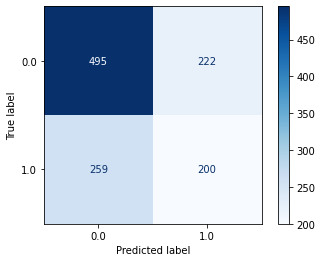

In [ ]:
# Matriz de confusão para o modelo KNN

plot_confusion_matrix(modelKNN, x_test, y_test, cmap='Blues', values_format='.0f')

* Analisando o resultado, percebe-se que o modelo k-nearest neighbors apresenta baixo desempenho, tendo uma acurácia de aproximadamente 0,60. Portanto, ele foi descartado como modelo principal.

### SVM (Support-Vector Machine)

In [ ]:
# --> TRAIN TEST SPLIT
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Divisão de x e y
x = df.drop(columns =['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

#Dados para treino e teste
x_train, x_test, y_train, y_test = train_test_split (x,y, test_size = 0.33, random_state = 42)

# --> SUPPORT VECTOR MACHINES
#Importando a biblioteca necessária
from sklearn import svm
from sklearn.svm import SVC

clf = svm.SVC()
modelSvm = clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
# Importando a biblioteca necessária para calcular as métricas
from sklearn import metrics

# Acurácia - Com que frequência o classificador está correto?
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

# Precisão - Das classificações positivas do modelo, quantas foram acertadas.
print("Precisão:",metrics.precision_score(y_test, y_pred))

# Revocação - Das amostras positivas existentes, quantas o modelo conseguiu classificar corretamente.
print("Revocação:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.6030927835051546
Precisão: 0.6
Recall: 0.01935483870967742


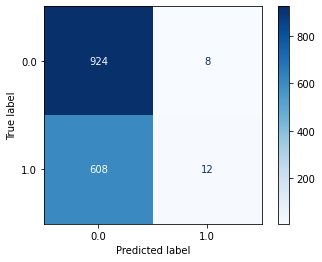

In [ ]:
# MATRIZ DE CONFUSÃO

from sklearn.tree import plot_tree
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(modelSvm, x_test, y_test, cmap='Blues', values_format='.0f')

* O modelo Support Vector Machine também foi descartado porque, além  de ter tido uma acurácia baixa (0.54), seu revocação e precisão foram de 0.0.

### **Random Forest**

No modelo Random Forest, a acurácia foi utilizada como métrica de avaliação. Para atingir o maior número, foram escolhas as profundidades máximas da árvore (max_depth) como sendo 2, 10, 15, 20, 25, 30, 40 e 50. Antes dos 20, todos ficaram com 0.693, a partir do 20, todos ficaram com uma acurácia de aproximadamente 0.98, por isso, usei como max_depth o valor 20!

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#declaro o nome do meu modelo, e declaro a profundade máxima em 20, já que entre 1 < 20 a acurácia é menor
# e entre 20> não há um aumento significante para a acurácia (valores testados: 2, 10, 15, 20, 25, 30, 40, 50)
clf = RandomForestClassifier(max_depth=20, random_state=0)
#treino meu modelo
clf.fit(x_train, y_train)
#ele prediz o x teste
y_pred = clf.predict(x_test)
#analiso a acurácia entre o teste e o que ele prediz
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Revocação:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.9890463917525774
Precisão 1.0
Recall: 0.9725806451612903


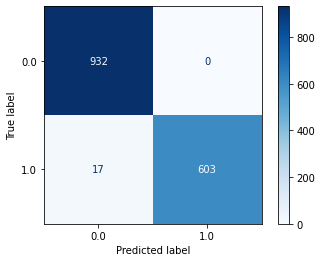

In [ ]:
plot_confusion_matrix(clf, x_test, y_test, cmap='Blues', values_format='.0f')

O modelo do random forest acertou muito bem, tendo uma acurácia de 0.98 e um recall de 0.96, foi uma das melhores performances de modelos, porém por não ser a melhor, descartamos essa opção também.

## Regressão Logística

In [ ]:
# Treinando o modelo
modelLog = LogisticRegression(max_iter=2000).fit(x_train, y_train)

# Fazendo as predições
y_pred = modelLog.predict(x_test)


# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.6275773195876289
Precisão 0.6363636363636364
Recall: 0.15806451612903225


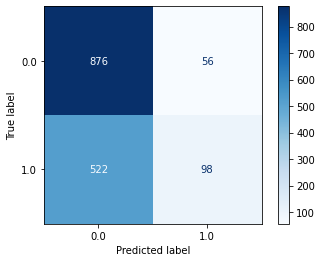

In [ ]:
# Matriz de confusão para o modelo de Regressão Logística

plot_confusion_matrix(modelLog, x_test, y_test, cmap='Blues', values_format='.0f')

Por ter um recall baixo e acurácia e precisão medianos, este também não será o nosso modelo final.

## Gaussian Naive Bayes

In [ ]:
# Treinando o modelo
modelGau = GaussianNB().fit(x_train, y_train)

# Fazendo as predições
y_pred = modelGau.predict(x_test)

# Calculando o erro r2- medida de qualidade do modelo
print("R ao quadrado:",r2_score(y_test, y_pred))

# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

R ao quadrado: 0.5111726429461443
Acurácia: 0.8827319587628866
Precisão 0.9888392857142857
Recall: 0.714516129032258


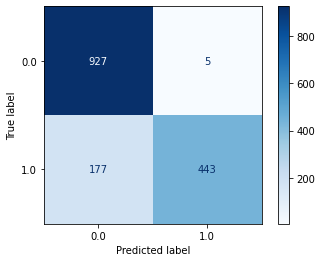

In [ ]:
plot_confusion_matrix(modelGau, x_test, y_test, cmap='Blues', values_format='.0f')

O GaussianNB não serviu como modelo principal pois desempenhou mal em todas as métricas escolhidas (abaixo de 0.6 em todas).

## Decision Tree

In [ ]:
# Dividindo x e y
x = df.drop(columns = ['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Treinando o modelo
modelTree = DecisionTreeClassifier(criterion='entropy', random_state=42).fit(x_train, y_train)

#criterion='entropy', random_state=42

# Fazendo as predições
y_pred = modelTree.predict(x_test)

# Calculando o erro r2- medida de qualidade do modelo
print("R ao quadrado:",r2_score(y_test, y_pred))

# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

R ao quadrado: 0.8934033153343655
Acurácia: 0.9744952178533475
Precisão 0.9532467532467532
Recall: 0.9839142091152815


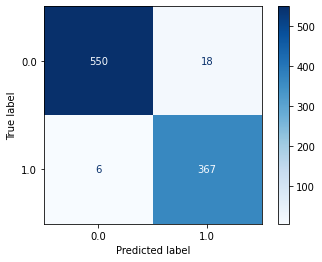

In [ ]:
plot_confusion_matrix(modelTree, x_test, y_test, cmap='Blues', values_format='.0f')

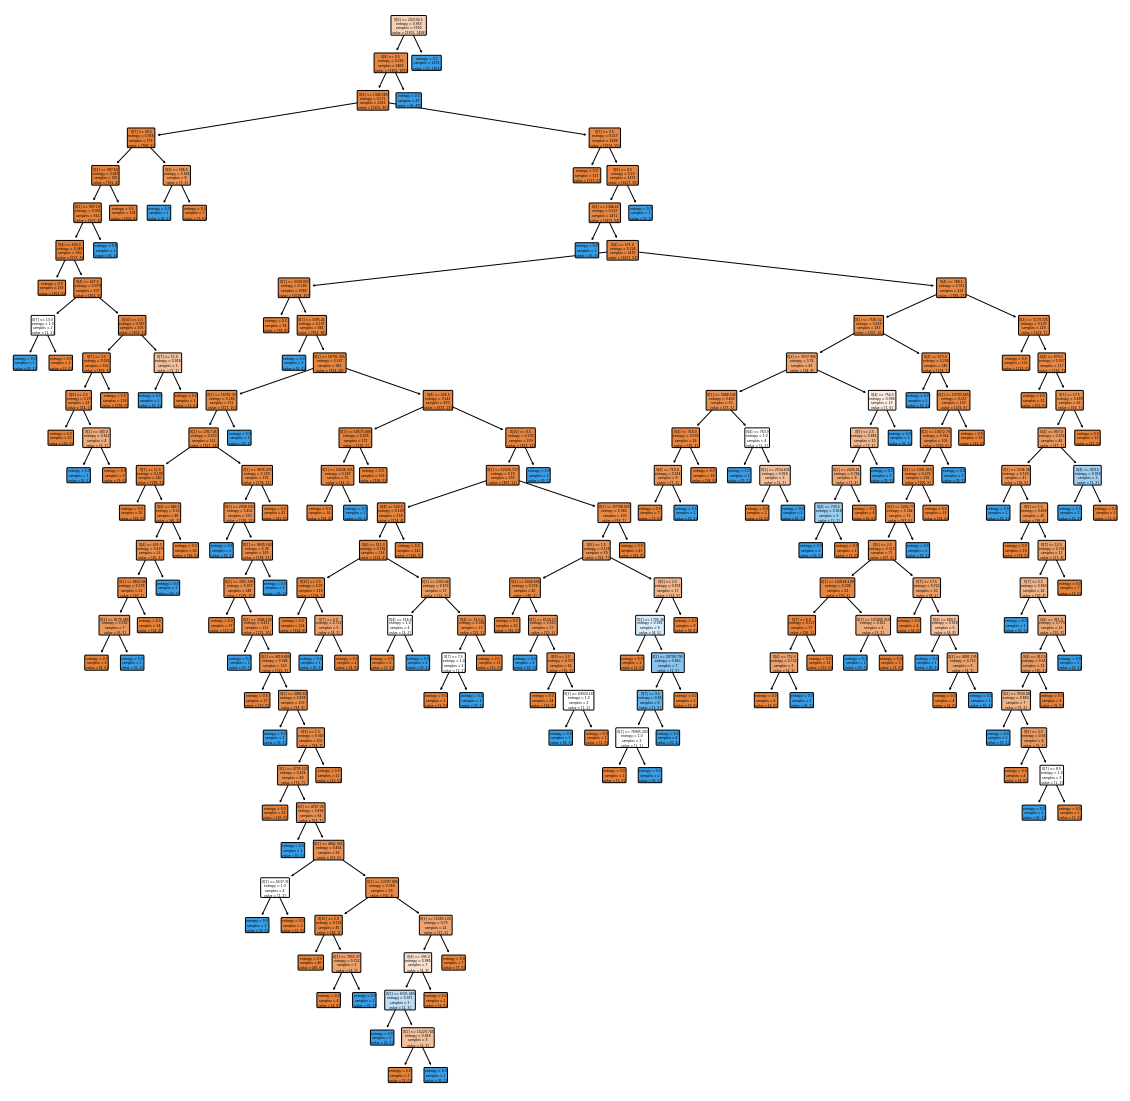

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
_ = plot_tree(modelTree,
            filled=True, rounded=True, ax=ax)
#Gera um arquivo no Notebook, que contém tal imagem com qualidade excelente
plt.savefig('out.pdf')

O modelo de decision tree classifier também foi bastante mediano em acurácia e precisão, porém consideramos ele também um forte candidato pelo bom número de recall.

## Gradient Boosting


--------------------------------------------------------------------
Learning rate:  0.05
Acurácia (treinamento): 0.971
Acurácia (teste): 0.976
Acurácia (final): 0.976
Precisão: 1.000
Recall: 0.938
--------------------------------------------------------------------
Learning rate:  0.075
Acurácia (treinamento): 0.974
Acurácia (teste): 0.983
Acurácia (final): 0.983
Precisão: 1.000
Recall: 0.957
--------------------------------------------------------------------
Learning rate:  0.1
Acurácia (treinamento): 0.977
Acurácia (teste): 0.984
Acurácia (final): 0.984
Precisão: 1.000
Recall: 0.960
--------------------------------------------------------------------
Learning rate:  0.25
Acurácia (treinamento): 0.984
Acurácia (teste): 0.993
Acurácia (final): 0.993
Precisão: 1.000
Recall: 0.981
--------------------------------------------------------------------
Learning rate:  0.5
Acurácia (treinamento): 0.984
Acurácia (teste): 0.991
Acurácia (final): 0.991
Precisão: 0.997
Recall: 0.981
-----------

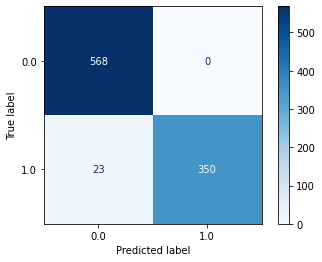

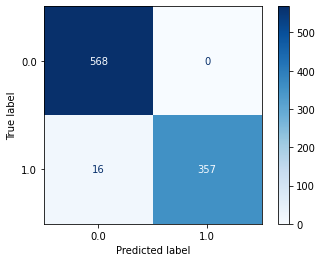

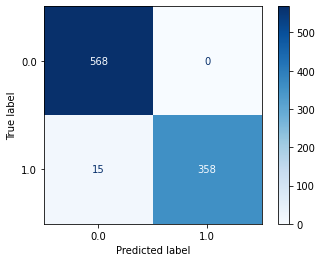

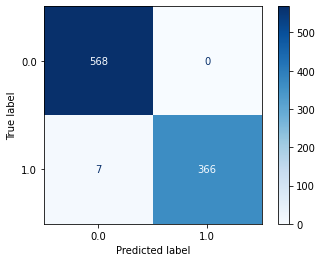

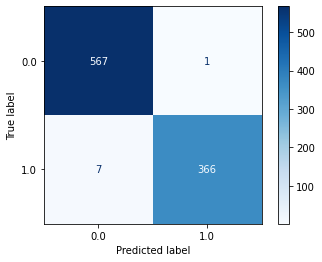

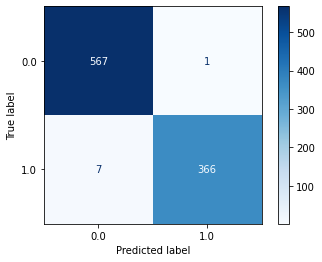

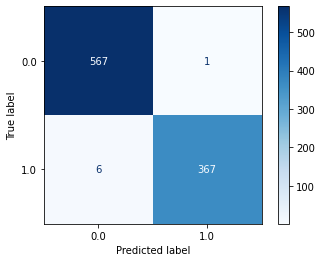

In [ ]:
# Dividindo x e y
x = df.drop(columns = ['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(x_train, y_train)

    # Fazendo as predições
    y_pred = gb_clf.predict(x_test)

    print("--------------------------------------------------------------------")
    print("Learning rate: ", learning_rate)
    print("Acurácia (treinamento): {0:.3f}".format(gb_clf.score(x_train, y_train)))
    print("Acurácia (teste): {0:.3f}".format(gb_clf.score(x_test, y_test)))
    print("Acurácia (final): {0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("Precisão: {0:.3f}".format(metrics.precision_score(y_test, y_pred)))
    print("Recall: {0:.3f}".format(metrics.recall_score(y_test, y_pred)))
    plot_confusion_matrix(gb_clf, x_test, y_test, cmap='Blues', values_format='.0f')

Por final, nosso modelo escolhido foi o Gradient Boosting, isso se deve por ele ter tido números incríveis de:
* Acurácia: 0.98
* Precisão: 0.99
* Recall: 0.96
Conforme a matriz de confusão mostra, houve muito pouco falsos positivos e falsos negativos.

#**Otimização e padronização dos modelos escolhidos:**

# Hiperparâmetros

Nos campos abaixo é possível encontrar a utilização do GridSearch e RandomSearch para encontrar os melhores hiperparametros da solução, com isso, buscando um melhor resultado alterando as configuração de parâmetros dos modelos de treino.

In [ ]:
# Importa bibliotecas dependentes

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Classe de hiperparâmetro

Classe que auxilia para reduzir a repetição de código na geração de novos hiperparametros para cada modelo, sendo Grid Search ou Random Search.

In [ ]:
class Hiperparametro:
    '''
    Classe para otimização de hiperparâmetros
    '''

    # Construtor da classe que recebe os dados de entrada para criação do modelo
    def __init__(self, modelo: object, parametros: dict, x: object, y: object, cv: int = 5, n_iter: int = 10, n_jobs: int = -1, verbose: int = 1, random_state: int = 42) -> None:
        self.modelo = modelo
        self.parametros = parametros
        self.n_iteracoes = n_iter
        self.n_jobs = n_jobs
        self.cv = cv
        self.random_state = random_state
        self.resultados = None

    # Método para poder gerar os resultados de treino por hiperparâmetros, tanto para RandomizedSearchCV quanto para GridSearchCV
    def busca(self, X: object, y: object, tipo: str) -> None:
        if tipo == 'grid':  # GridSearchCV
            # Cria o objeto de busca de hiperparâmetros
            self.resultados = GridSearchCV(self.modelo, self.parametros,
                                           cv=self.cv, n_jobs=self.n_jobs)
        elif tipo == 'random':  # RandomizedSearchCV
            # Cria o objeto de busca de hiperparâmetros
            self.resultados = RandomizedSearchCV(self.modelo, self.parametros, n_iter=self.n_iteracoes,
                                                 cv=self.cv, n_jobs=self.n_jobs, random_state=self.random_state)
        else:
            raise Exception('Tipo de busca inválido')

        # Treina o modelo com os dados de entrada
        self.resultados.fit(X, y)
        self.resultados

    def escrever_resultados(self) -> None:
        # Escreve os resultados no terminal
        print('Melhor score: %s' % self.resultados.best_score_)
        print('Melhores hiperparâmetros: %s' % self.resultados.best_params_)

## Geração dos modelos

Nos blocos de código abaixo é possível ver a geração dos melhores modelos possíveis pelos hiperparâmetros inseridos, utilizando a estratégia de Grid e Random.

### KNN (K-Nearest Neighbor)

In [ ]:
'''KNN - KNeighborsClassifier'''
KNN_parametros = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(10, 60, 10)
}
KNN_hi = Hiperparametro(KNeighborsClassifier(), KNN_parametros, 4, -1, 5, 42)
# --------------------------------------------------------

print('KNN:\n')
print('Busca aleatória:')
KNN_hi.busca(x_train, y_train, 'random')
KNN_hi.escrever_resultados()
print('')
print('Busca em grade:')
KNN_hi.busca(x_train, y_train, 'grid')
KNN_hi.escrever_resultados()

KNN:

Busca aleatória:
Melhor score: 0.6236702127659575
Melhores hiperparâmetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan', 'leaf_size': 20, 'algorithm': 'kd_tree'}

Busca em grade:
Melhor score: 0.6236702127659575
Melhores hiperparâmetros: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}


#### Modelo KNN com os hiperparâmetros recomendados pelo Random Search:


In [ ]:
# Treinando o modelo

modelKNN = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='manhattan', leaf_size=20, algorithm='kd_tree')

modelKNN.fit(x_train, y_train)

# Realizando as predições

y_pred = modelKNN.predict(x_test)

# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.6014877789585548
Precisão 0.4966216216216216
Recall: 0.3941018766756032


#### Modelo KNN com os hiperparâmetros recomendados pelo Grid Search:


In [ ]:
# Treinando o modelo

modelKNN = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='manhattan', leaf_size=10, algorithm='auto')

modelKNN.fit(x_train, y_train)

# Realizando as predições

y_pred_3 = modelKNN.predict(x_test)

# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.6014877789585548
Precisão 0.4966216216216216
Recall: 0.3941018766756032


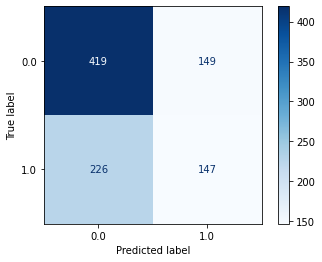

In [ ]:
plot_confusion_matrix(modelKNN, x_test, y_test, cmap='Blues', values_format='.0f')

### Random Forest

In [ ]:
'''Random Forest'''
RF_parametros = {
    'n_estimators': [10, 50, 100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 7, 9],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

RF_hi = Hiperparametro(RandomForestClassifier(), RF_parametros, 4, -1, 5, 42)
# --------------------------------------------------------

print('Random Forest:\n')
print('Busca aleatória:')
RF_hi.busca(x_train, y_train, 'random')
RF_hi.escrever_resultados()
print('')
print('Busca em grade:')
RF_hi.busca(x_train, y_train, 'grid')
RF_hi.escrever_resultados()

Random Forest:

Busca aleatória:
Melhor score: 0.9843085106382977
Melhores hiperparâmetros: {'n_estimators': 10, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'gini'}

Busca em grade:
Melhor score: 0.9843085106382977
Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 10}


#### Modelo Random Forest com os hiperparâmetros recomendados pelo Random Search:



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#declaro o nome do meu modelo, e declaro a profundade máxima em 20, já que entre 1 < 20 a acurácia é menor
# e entre 20> não há um aumento significante para a acurácia (valores testados: 2, 10, 15, 20, 25, 30, 40, 50)
clf = RandomForestClassifier(n_estimators=10, max_features='auto', max_depth=7, criterion='gini', random_state=0)
#treino meu modelo
clf.fit(x_train, y_train)
#ele prediz o x teste
y_pred = clf.predict(x_test)
#analiso a acurácia entre o teste e o que ele prediz
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.9925611052072264
Precisão 1.0
Recall: 0.9812332439678284


#### Modelo Random Forest com os hiperparâmetros recomendados pelo Grid Search:



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#declaro o nome do meu modelo, e declaro a profundade máxima em 20, já que entre 1 < 20 a acurácia é menor
# e entre 20> não há um aumento significante para a acurácia (valores testados: 2, 10, 15, 20, 25, 30, 40, 50)
clf = RandomForestClassifier(n_estimators=10, max_features='auto', max_depth=9, criterion='entropy', random_state=0)
#treino meu modelo
clf.fit(x_train, y_train)
#ele prediz o x teste
y_pred = clf.predict(x_test)
#analiso a acurácia entre o teste e o que ele prediz
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.9914984059511158
Precisão 0.997275204359673
Recall: 0.9812332439678284


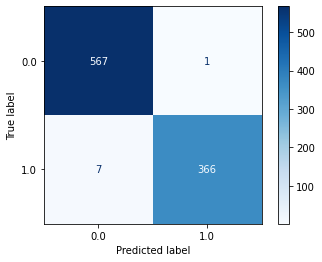

In [ ]:
plot_confusion_matrix(clf, x_test, y_test, cmap='Blues', values_format='.0f')

### SVM (Support-Vector Machine)

In [ ]:
'''SVM - Support Vector Machine'''
SVM_parametros = {
    #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'probability': [True, False],
}

SVM_hi = Hiperparametro(SVC(), SVM_parametros, 4, -1, 5, 42)
# --------------------------------------------------------

print('SVM:')
print('Busca aleatória:\n')
SVM_hi.busca(x_train, y_train, 'random')
SVM_hi.escrever_resultados()
print('')
print('Busca em grade:')
SVM_hi.busca(x_train, y_train, 'grid')
SVM_hi.escrever_resultados()

SVM:
Busca aleatória:

Melhor score: 0.6132978723404255
Melhores hiperparâmetros: {'shrinking': True, 'probability': True, 'gamma': 'auto', 'degree': 2}

Busca em grade:
Melhor score: 0.6132978723404255
Melhores hiperparâmetros: {'degree': 2, 'gamma': 'auto', 'probability': True, 'shrinking': True}


#### Modelo SVM com os hiperparâmetros recomendados pelo Random Search:


In [ ]:
# --> TRAIN TEST SPLIT
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Divisão de x e y
x = df.drop(columns =['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

#Dados para treino e teste
x_train, x_test, y_train, y_test = train_test_split (x,y, test_size = 0.33, random_state = 42)

# --> SUPPORT VECTOR MACHINES
#Importando a biblioteca necessária
from sklearn import svm
from sklearn.svm import SVC

clf = svm.SVC(degree=2, gamma='auto', probability=True, shrinking=True)
modelSvm = clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

#Importando a biblioteca necessária para calcular as métricas
from sklearn import metrics

#Acurácia - Com que frequência o classificador está correto?
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

#Precisão - Das classificações positivas do modelo, quantas foram acertadas.
print("Precisão:",metrics.precision_score(y_test, y_pred))

#Revocação - Das amostras positivas existentes, quantas o modelo conseguiu classificar corretamente.
print("Recall:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.6005154639175257
Precisão: 0.0
Recall: 0.0


#### Modelo SVM com os hiperparâmetros recomendados pelo Grid Search:


In [ ]:
# --> TRAIN TEST SPLIT
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Divisão de x e y
x = df.drop(columns =['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

#Dados para treino e teste
x_train, x_test, y_train, y_test = train_test_split (x,y, test_size = 0.33, random_state = 42)

# --> SUPPORT VECTOR MACHINES
#Importando a biblioteca necessária
from sklearn import svm
from sklearn.svm import SVC

clf = svm.SVC(degree=2, gamma='auto', probability=True, shrinking=True)
modelSvm = clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

#Importando a biblioteca necessária para calcular as métricas
from sklearn import metrics

#Acurácia - Com que frequência o classificador está correto?
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

#Precisão - Das classificações positivas do modelo, quantas foram acertadas.
print("Precisão:",metrics.precision_score(y_test, y_pred))

#Revocação - Das amostras positivas existentes, quantas o modelo conseguiu classificar corretamente.
print("Recall:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.6005154639175257
Precisão: 0.0
Recall: 0.0


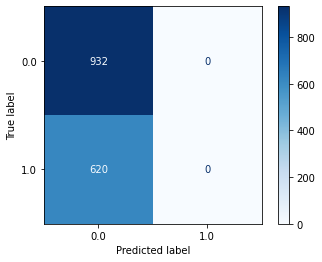

In [ ]:
plot_confusion_matrix(modelSvm, x_test, y_test, cmap='Blues', values_format='.0f')

### Gradient Boosting

In [ ]:
''' Gradient Boosting '''
GB_parametros = {
    'n_estimators': [10, 50, 100, 200, 500],
    'criterion': ['friedman_mse', 'mse', 'mae'],
    'max_depth': [3, 5, 7, 9],
    #'max_features': [None, 'auto', 'sqrt', 'log2'],
    #'warm_start': [False, True],
}

GB_hi = Hiperparametro(GradientBoostingClassifier(),
                       GB_parametros, 4, -1, 5, 42)
# --------------------------------------------------------

print('Gradient Boosting:\n')
print('Busca aleatória:')
GB_hi.busca(x_train, y_train, 'random')
GB_hi.escrever_resultados()
print('')
print('Busca em grade:')
GB_hi.busca(x_train, y_train, 'grid')
GB_hi.escrever_resultados()

Gradient Boosting:

Busca aleatória:
Melhor score: 0.9841224417695006
Melhores hiperparâmetros: {'n_estimators': 10, 'max_depth': 3, 'criterion': 'friedman_mse'}

Busca em grade:
Melhor score: 0.9841224417695006
Melhores hiperparâmetros: {'criterion': 'friedman_mse', 'max_depth': 3, 'n_estimators': 10}


#### Modelo Gradient Boosting com os hiperparâmetros recomendados pelo Random Search:

In [ ]:
# Dividindo x e y
x = df.drop(columns = ['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=10, criterion='friedman_mse', learning_rate=learning_rate, max_depth=3, random_state=0)
    gb_clf.fit(x_train, y_train)

    # Fazendo as predições
    y_pred = gb_clf.predict(x_test)

    print("--------------------------------------------------------------------")
    print("Learning rate: ", learning_rate)
    print("Acurácia (treinamento): {0:.3f}".format(gb_clf.score(x_train, y_train)))
    print("Acurácia (teste): {0:.3f}".format(gb_clf.score(x_test, y_test)))
    print("Acurácia (final): {0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("Precisão: {0:.3f}".format(metrics.precision_score(y_test, y_pred)))
    print("Recall: {0:.3f}".format(metrics.recall_score(y_test, y_pred)))
    #plot_confusion_matrix(gb_clf, x_test, y_test, cmap='Blues', values_format='.0f')

--------------------------------------------------------------------
Learning rate:  0.05
Acurácia (treinamento): 0.984
Acurácia (teste): 0.993
Acurácia (final): 0.993
Precisão: 0.997
Recall: 0.984
--------------------------------------------------------------------
Learning rate:  0.075
Acurácia (treinamento): 0.984
Acurácia (teste): 0.993
Acurácia (final): 0.993
Precisão: 0.997
Recall: 0.984
--------------------------------------------------------------------
Learning rate:  0.1
Acurácia (treinamento): 0.984
Acurácia (teste): 0.993
Acurácia (final): 0.993
Precisão: 0.997
Recall: 0.984
--------------------------------------------------------------------
Learning rate:  0.25
Acurácia (treinamento): 0.984
Acurácia (teste): 0.993
Acurácia (final): 0.993
Precisão: 0.997
Recall: 0.984
--------------------------------------------------------------------
Learning rate:  0.5
Acurácia (treinamento): 0.986
Acurácia (teste): 0.993
Acurácia (final): 0.993
Precisão: 0.997
Recall: 0.984
-----------

#### Modelo Gradient Boosting com os hiperparâmetros recomendados pelo Grid Search:

In [ ]:
# Dividindo x e y
x = df.drop(columns = ['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=10, criterion='friedman_mse', learning_rate=learning_rate, max_depth=3, random_state=0)
    gb_clf.fit(x_train, y_train)

    # Fazendo as predições
    y_pred = gb_clf.predict(x_test)

    print("--------------------------------------------------------------------")
    print("Learning rate: ", learning_rate)
    print("Acurácia (treinamento): {0:.3f}".format(gb_clf.score(x_train, y_train)))
    print("Acurácia (teste): {0:.3f}".format(gb_clf.score(x_test, y_test)))
    print("Acurácia (final): {0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("Precisão: {0:.3f}".format(metrics.precision_score(y_test, y_pred)))
    print("Recall: {0:.3f}".format(metrics.recall_score(y_test, y_pred)))
    #plot_confusion_matrix(gb_clf, x_test, y_test, cmap='Blues', values_format='.0f')

--------------------------------------------------------------------
Learning rate:  0.05
Acurácia (treinamento): 0.984
Acurácia (teste): 0.993
Acurácia (final): 0.993
Precisão: 0.997
Recall: 0.984
--------------------------------------------------------------------
Learning rate:  0.075
Acurácia (treinamento): 0.984
Acurácia (teste): 0.993
Acurácia (final): 0.993
Precisão: 0.997
Recall: 0.984
--------------------------------------------------------------------
Learning rate:  0.1
Acurácia (treinamento): 0.984
Acurácia (teste): 0.993
Acurácia (final): 0.993
Precisão: 0.997
Recall: 0.984
--------------------------------------------------------------------
Learning rate:  0.25
Acurácia (treinamento): 0.984
Acurácia (teste): 0.993
Acurácia (final): 0.993
Precisão: 0.997
Recall: 0.984
--------------------------------------------------------------------
Learning rate:  0.5
Acurácia (treinamento): 0.986
Acurácia (teste): 0.993
Acurácia (final): 0.993
Precisão: 0.997
Recall: 0.984
-----------

### Decision Tree

In [ ]:
''' Decision Tree Classifier '''
DTC_parametros = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 3, 5, 7, 9],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

DTC_hi = Hiperparametro(DecisionTreeClassifier(),
                        DTC_parametros, 4, -1, 5, 42)
# --------------------------------------------------------

print('Decision Tree Classifier:\n')
print('Busca aleatória:')
DTC_hi.busca(x_train, y_train, 'random')
DTC_hi.escrever_resultados()
print('')
print('Busca em grade:')
DTC_hi.busca(x_train, y_train, 'grid')
DTC_hi.escrever_resultados()

Decision Tree Classifier:

Busca aleatória:
Melhor score: 0.9840425531914893
Melhores hiperparâmetros: {'splitter': 'random', 'max_features': None, 'max_depth': 9, 'criterion': 'entropy'}

Busca em grade:
Melhor score: 0.9840425531914893
Melhores hiperparâmetros: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'splitter': 'best'}


#### Modelo Decision Tree Classifier com os hiperparâmetros recomendados pelo Random Search:

In [ ]:
# Dividindo x e y
x = df.drop(columns = ['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Treinando o modelo
modelTree = DecisionTreeClassifier(criterion='gini', max_features=None, max_depth=9, splitter='random', random_state=42).fit(x_train, y_train)

#criterion='entropy', random_state=42

# Fazendo as predições
y_pred = modelTree.predict(x_test)

# Calculando o erro r2- medida de qualidade do modelo
print("R ao quadrado:",r2_score(y_test, y_pred))

# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

R ao quadrado: 0.9600262432503871
Acurácia: 0.9904357066950054
Precisão 0.9918918918918919
Recall: 0.9839142091152815


#### Modelo Decision Tree Classifier com os hiperparâmetros recomendados pelo Grid Search:

In [ ]:
# Dividindo x e y
x = df.drop(columns = ['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Treinando o modelo
modelTree = DecisionTreeClassifier(criterion='gini', max_features=None, max_depth=3, splitter='best', random_state=42).fit(x_train, y_train)

#criterion='entropy', random_state=42

# Fazendo as predições
y_pred = modelTree.predict(x_test)

# Calculando o erro r2- medida de qualidade do modelo
print("R ao quadrado:",r2_score(y_test, y_pred))

# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

R ao quadrado: 0.9689093003058566
Acurácia: 0.9925611052072264
Precisão 0.9972826086956522
Recall: 0.9839142091152815


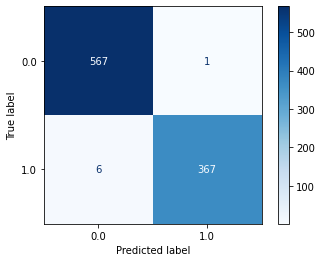

In [ ]:
plot_confusion_matrix(modelTree, x_test, y_test, cmap='Blues', values_format='.0f')

### Gaussian Naive Bayes

In [ ]:
''' GaussianNB '''
GNB_parametros = {
    # Não há valores para este parâmetro ( apenas para manter o padrão )
    'priors': [None],

    'var_smoothing': np.logspace(0, -9, num=100)
}

GNB_hi = Hiperparametro(GaussianNB(), GNB_parametros, 4, -1, 5, 42)
# --------------------------------------------------------

print('GaussianNB:\n')
print('Busca aleatória:')
GNB_hi.busca(x_train, y_train, 'random')
GNB_hi.escrever_resultados()
print('')
print('Busca em grade:')
GNB_hi.busca(x_train, y_train, 'grid')
GNB_hi.escrever_resultados()

GaussianNB:

Busca aleatória:
Melhor score: 0.8534574468085108
Melhores hiperparâmetros: {'var_smoothing': 1.873817422860387e-09, 'priors': None}

Busca em grade:
Melhor score: 0.8845744680851064
Melhores hiperparâmetros: {'priors': None, 'var_smoothing': 1e-09}


#### Modelo Gaussian Naive Bayes com os hiperparâmetros padrões:

In [ ]:
# Treinando o modelo
modelGau = GaussianNB().fit(x_train, y_train)

# Fazendo as predições
y_pred = modelGau.predict(x_test)

# Calculando o erro r2- medida de qualidade do modelo
print("R ao quadrado:",r2_score(y_test, y_pred))

# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

R ao quadrado: 0.5247564475323794
Acurácia: 0.8862911795961743
Precisão 0.9925925925925926
Recall: 0.7184986595174263


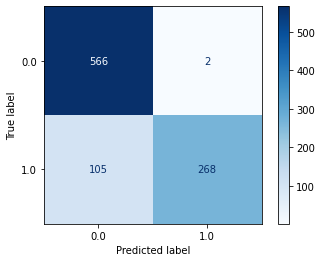

In [ ]:
plot_confusion_matrix(modelGau, x_test, y_test, cmap='Blues', values_format='.0f')

### Regressão Logística

In [ ]:
''' Logistic Regression '''
LR_parametros = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'dual': [False, True],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'multi_class': ['auto', 'ovr', 'multinomial'],
}

LR_hi = Hiperparametro(LogisticRegression(), LR_parametros, 4, -1, 5, 42)
# --------------------------------------------------------

print('Logistic Regression:\n')
print('Busca aleatória:')
LR_hi.busca(x_train, y_train, 'random')
LR_hi.escrever_resultados()
print('')
print('Busca em grade:')
LR_hi.busca(x_train, y_train, 'grid')
LR_hi.escrever_resultados()

Logistic Regression:

Busca aleatória:
Melhor score: 0.6925999949529361
Melhores hiperparâmetros: {'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'multinomial', 'fit_intercept': True, 'dual': False}

Busca em grade:
Melhor score: 0.6929179599767835
Melhores hiperparâmetros: {'dual': False, 'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'none', 'solver': 'newton-cg'}


#### Modelo Regressão Logística com os hiperparâmetros recomendados pelo Random Search:

In [ ]:
# Treinando o modelo
modelLog = LogisticRegression(solver='newton-cg',penalty='none',multi_class='multinomial',fit_intercept=True,dual=False,max_iter=2000).fit(x_train, y_train)

# Fazendo as predições
y_pred = modelLog.predict(x_test)


# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.6907545164718385
Precisão 0.9880952380952381
Recall: 0.2225201072386059


#### Modelo Regressão Logística com os hiperparâmetros recomendados pelo Grid Search:

In [ ]:
# Treinando o modelo
modelLog = LogisticRegression(solver='newton-cg',penalty='none',multi_class='multinomial',fit_intercept=True,dual=False,max_iter=2000).fit(x_train, y_train)

# Fazendo as predições
y_pred = modelLog.predict(x_test)


# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.6907545164718385
Precisão 0.9880952380952381
Recall: 0.2225201072386059


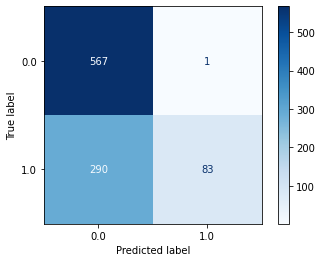

In [ ]:
plot_confusion_matrix(modelLog, x_test, y_test, cmap='Blues', values_format='.0f')

## Estabilidade dos dados

Quanto à questão de divisão dos dados para teste e treinamento, é possível afirmar que há estabilidade, tendo em vista que, durante o processo de tratamento e limpeza de dados, são rodados algoritmos padrozinados, sempre com a base em uma posição padrão. Assim, os dados são igualmente mantidos quando tais procedimentos são finalizados. Desse modo, as únicas questões que poderiam causar instabilidade nessa divisão já foram corrigidas com êxito, sendo essas correções concretizadas através da randomização dos dados após o procedimento de balancemanento dos mesmos, no qual o procedimento utilizado para resolução foi o de sempre efetuar essa randomização de forma igualitária, utilizando o parâmetro “seed” do Scikit-Learn. O segundo ponto que causava instabilidade era justamente na divisão de treinamento e teste, contudo, essa falha foi corrigida de modo semelhante à anterior: utilizando o parâmetro “seed” do Scikit-Learn, garantimos que, sempre que a seperação seja feita, ela ocorra no mesmo local, corrigindo assim mais uma vez o problema da instabilidade dos dados na separação.

# Estratégia de avaliação escolhida

Frente à diversidade de formas de avaliar algoritmos de predição, fez-se necessário escolher a estratégia de avaliação que melhor se adequasse aos modelos de classificação, bem como a que melhor pudesse atender às demandas do cliente.

Destaca-se, sobre esse aspecto, que a avaliação de algoritmos supervisionados deve ser realizada com base no desempenho que o modelo apresenta ao se deparar com o desafio de rotular novos objetos, com os quais não teve contato prévio na fase de treinamento.

As métricas extraídas de cada algoritmo testado foram acurácia, precisão e recall. Além disso, foram utilizadas matrizes de confusão, a fim de conferir a proporção de erros e acertos gerados pelos modelos.

Diante do problema trazido pelo Banco Pan, é preferível que o algoritmo escolhido apresente casos de falso positivo do que casos de falso negativos. Ou seja, seria mais adequado utilizar a métrica de **recall** (revocação), que apresenta a proporção de acertos do modelo (verdadeiros positivos) em relação ao total de casos verdadeiros, bem como a **matriz de confusão**. A **acurácia**, que revela a porcentagem total de acertos do modelo

# Resultados preliminares obtidos

A partir de nossos resultados obtidos a partir da execução de 7 diferentes tipos de modelo para a mesma base de dados, a conclusão obtida pelo grupo foi os seguintes modelos performaram melhor:


*   *Random Forest*
*   *Decision Tree*
*   *Gradient Boosting*


Com esses três modelos em mãos, foi necessário efetuar uma seleção preliminar do melhor modelo a ser utilizado, resultando assim na escolha do Gradient Boosting com um learning rate de 0.5. Essa decisão foi apoiada no fato de que, além do Gradient Boosting possuir um maior nível de acerto generalizado, com esse learning rate específico, foi possível obter uma porcentagem de acertos alta e uma quantidade pequena de falsos negativos, o que é excelente para o objetivo para o qual o modelo foi produzido. Justifica-se essa decisão a partir do fato de que o falso negativo é o resultado que traria maior risco de uma insatisfação do cliente após finalizar o atendimento, devido ao fato de que o atendente receberia a informação de que ele não é atritado ao passo em que ele é, na verdade, um cliente atritado, não exercendo então um tratamento diferenciado a esse cliente, causando assim, na maioria dos casos, sua insatisfação. 

# Resultados obtidos a partir da otimização dos hiperparâmetros dos modelos

Os algoritmos testados para a composição do modelo preditivo foram refinados por meio das técnicas de Random Search e Grid Search, que constituem métodos eficientes para ajustes de hiperparâmetros. Esses processos realizam uma seleção apurada dos valores que melhor preenchem os hiperparâmetros, promovendo a otimização das predições realizadas.

**KNN (K-Nearest Neighbor)**

O modelo KNN, embora submetido à otimização dos parâmetros que o compõem, não apresentou o mínimo resultado esperado para ser considerado no nosso modelo preditivo. Para ambas as técnicas às quais foi submetido, apresentou acurácia 1% maior do que com os parâmetros padrões (60%), além de precisão 2% superior, de 49,6%. O recall, que constitui uma métrica importante para o modelo, foi 4% inferior (39,4%) — principal motivo pelo qual o algoritmo em questão foi rejeitado.



**SVM (Support-Vector Machine)**

O algoritmo em questão apresentou um desempenho questionável quanto às métricas extraídas. A partir dos ajustes de hiperparâmetros, obtivemos a mesma acurácia (60%), enquanto a precisão foi de 60% para 0%, mesmo índice obtido para o recall, que já era muito baixo. Assim, o modelo não será considerado. 

**Regressão Logística**

O modelo de regressão logística não apresentou o desempenho esperado. Uma vez ajustados os valores dos parâmetros, a acurácia aumentou em 6%, chegando a 69%. A precisão chegou a 98%, mas o recall, que já era baixo, não foi satisfatório: 22,2%. Esse resultado fez com que o algoritmo fosse descartado também.

**Gaussian Naive Bayes**

O desempenho do modelo gaussiano foi mais satisfatório do que os anteriores. A precisão chegou a 99,2% frente ao ajuste feito a partir do Random Search e do Grid Search. Contudo, a acurácia máxima foi de 88,6%, e o recall, métrica mais importante, chegou somente a 71,8%. Logo, foram priorizados os modelos que performaram melhor.

**Decision Tree**

Decision Tree foi um algoritmo que performou bem antes e depois dos ajustes, apresentando melhoras: a acurácia máxima foi de 99,2%, a precisão chegou a 99,7% e o recall obtido foi de 98,3%. Assim, o modelo foi considerado, ainda que os algoritmos restantes tenham demonstrado um desempenho superior.

**Random Forest**

O algoritmo apresentou o segundo melhor desempenho, e as estatísticas não se alteraram significamente com o ajuste dos parâmetros: a acurácia foi a 99,1%, a precisão alcançou 100% e o recall máximo foi de 98,1%. Portanto, constitui um dos modelos mais favoráveis ao objetivo do grupo.

**Gradient Boosting**

Apresentando um desempenho excelente, Gradient Boosting é o favorito à decisão de modelo final. Posteriormente à otimização dos hiperparâmetros, sua acurácia foi de 99,1% a 99,3%, enquanto a precisão e o recall chegaram a 99,7% e 98,4%, respectivamente. As estatísticas apresentadas foram as mais altas entre todos os algoritmos testados.